# AML Assignment 3 Submission

|Name | RollNo|
|-----|-------|
|Aman | MDS202305 |
|Ankan Kar| MCS202303 |
|Utpalraj Kemprai| MDS202352 |

------------





# Understanding the Acrobot Environment

The Acrobot is a pendulum-like system with two links and two joints. The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques to the joints to swing the end of the second link (the tip) to a target height above the horizontal axis.

---

**Actions**

Discrete action space: The environment has a discrete action space of size 3, corresponding to the torque applied to the joints:
  
  
  | Num | Action | Unit |
  |-----|--------|------|
  | 0   | apply -1 torque to the actuated joint | torque (N m)|
  | 1   | apply 0 torque to the actuated joint  | torque (N m)|
  | 2   | apply 1 torque to the actuated joint  | torque (N m)|

---

  **Environment States**

  - State Space
  

  | Num | Observation                 | Min  | Max  |
  |-----|-----------------------------|------|------|
  | 0   | cosine of `theta1`          |  -1  |  1   |
  | 1   | sine of `theta1`            |  -1  |  1   |
  | 2   | cosine of `theta2`          |  -1  |  1   |
  | 3   | sine of `theta12`           |  -1  |  1   |
  | 4   | Angular velocity of `theta1`| - 4π |  4π  |
  | 5   | Angular velocity of `theta2`| - 9π |  9π  |

  where

- `theta1` is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.

- `theta2` is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

---

**Rewards**

The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.

---

**Starting State**

Each parameter in the underlying state (`theta1`, `theta2`, and the two angular velocities) is initialized uniformly between -0.1 and 0.1. This means both links are pointing downwards with some initial stochasticity.

---
**Episode End**

The episode ends if one of the following occurs:

1. Termination: The free end reaches the target height, which is constructed as:

 $-cos$(`theta1`) $- cos$(`theta2` $+$ `theta1`) > 1.0

2. Truncation: Episode length is greater than 500

---



# Importing the libraries

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Installing gymnasium

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
# create the environment
env = gym.make('Acrobot-v1', render_mode="rgb_array")

In [ ]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<AcrobotEnv<Acrobot-v1>>>>>

## Initial state

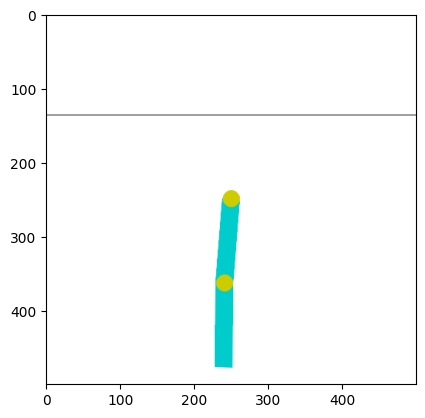

In [ ]:
# sample image of initial state
env.reset()
frame = env.render()
plt.grid(False)
plt.imshow(frame)
plt.show()

## Function to save an episode as gif and display it later

In [ ]:
from PIL import Image as Img

def create_gif(frames, output_gif_path, duration=100):
    images = [Img.fromarray(frame) for frame in frames]
    # Save as GIF
    images[0].save(
    output_gif_path,
    save_all=True,
    append_images=images[1:],
    duration=duration, # duration for each frame in milliseconds
    loop=0 # 0 means infinite loop
    )

# Performance of random agent

Play a game  

In [ ]:
frames = []
env.reset()
total_reward = 0
done = False
while not done:
    action = env.action_space.sample() # select an action at random
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = env.render()
    frames.append(frame)
    if done:
        break

print("Game terminated after", len(frames), " steps with reward ", total_reward)

Game terminated after 500  steps with reward  -500.0


Display as a gif

In [ ]:
# save as gif
create_gif(frames, output_gif_path='/content/random_agent.gif', duration=100)

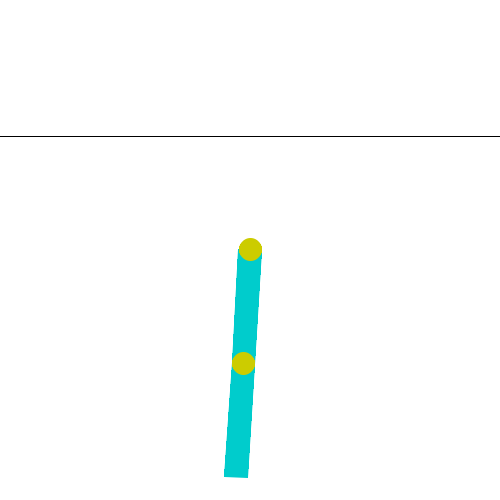

In [ ]:
# display the random_agent.gif
from IPython.display import Image, display
display(Image(filename='/content/random_agent.gif', width=400, height=300, embed=True))

## Average reward for the random agent on 100 games

In [ ]:
# play 100 episodes with random agent and get average reward
rewards = []
num_episodes = 100
for j in range(num_episodes):
    env.reset()
    frames = []
    total_reward = 0
    while True:
        action = env.action_space.sample()
        pesudo_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        frame = env.render()
        frames.append(frame)

        if done:
            break

    print(f"Game {j+1}/{num_episodes} , terminated after : {len(frames)} steps, with reward : {total_reward}")
    rewards.append(total_reward)

random_agent_mean = np.mean(rewards)
random_agent_median = np.median(rewards)
random_agent_std = np.std(rewards)
random_agent_max = np.max(rewards)
random_agent_min = np.min(rewards)

Game 1/100 , terminated after : 500 steps, with reward : -500.0
Game 2/100 , terminated after : 500 steps, with reward : -500.0
Game 3/100 , terminated after : 500 steps, with reward : -500.0
Game 4/100 , terminated after : 500 steps, with reward : -500.0
Game 5/100 , terminated after : 500 steps, with reward : -500.0
Game 6/100 , terminated after : 500 steps, with reward : -500.0
Game 7/100 , terminated after : 500 steps, with reward : -500.0
Game 8/100 , terminated after : 500 steps, with reward : -500.0
Game 9/100 , terminated after : 500 steps, with reward : -500.0
Game 10/100 , terminated after : 500 steps, with reward : -500.0
Game 11/100 , terminated after : 500 steps, with reward : -500.0
Game 12/100 , terminated after : 500 steps, with reward : -500.0
Game 13/100 , terminated after : 500 steps, with reward : -500.0
Game 14/100 , terminated after : 500 steps, with reward : -500.0
Game 15/100 , terminated after : 500 steps, with reward : -500.0
Game 16/100 , terminated after : 5

Performance of the random agent

In [ ]:
print("Random Agent")
print("Average reward:", random_agent_mean)
print("Median reward:", random_agent_median)
print("Standard deviation:", random_agent_std)
print("Maximum reward:", random_agent_max)
print("Minimum reward:", random_agent_min)

Random Agent
Average reward: -499.0
Median reward: -500.0
Standard deviation: 6.749814812274482
Maximum reward: -448.0
Minimum reward: -500.0


# Training a DQN model

In [ ]:
# Create the environment
env = gym.make("Acrobot-v1", render_mode = "rgb_array")

# Reset the environment
observation = env.reset()

# Set up the device to use (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(device)

cpu


### Building the Deep Q Network

The DQN architecture is defined in the DQN class, which is a neural network with three layers: two hidden layers with 128 neurons each and one output layer with the number of neurons equal to the number of actions. The forward() function defines the forward pass through the network.

In [ ]:
class DQN(nn.Module):
    """
    Deep Q-Network (DQN) class.

    Parameters:
        n_observations (int): Number of observations (input size).
        n_actions (int): Number of possible actions (output size).
    """

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128) # First hidden layer with 128 neurons
        self.layer2 = nn.Linear(128, 128) # Second hidden layer with 128 neurons
        self.layer3 = nn.Linear(128, n_actions) # Output layer with n_actions neurons

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
            x (tensor): Input tensor with shape (batch_size, n_observations).

        Returns:
            tensor: Output tensor with shape (batch_size, n_actions).
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

- We then set up hyperparameters and initializing a reinforcement learning environment with a neural network-based policy network and a target network.

- The hyperparameters of the DQN algorithm are set as follows: `BATCH_SIZE` is the number of transitions sampled from the replay buffer, `GAMMA` is the discount factor, `EPS_START` and `EPS_END` are the starting and ending values of epsilon for the epsilon-greedy strategy, `EPS_DECAY` controls the rate of exponential decay of epsilon, `TAU` is the update rate of the target network, and `LR` is the learning rate of the optimizer.

- The policy network's weights are loaded onto the target network. The code also initializes the optimizer for the policy network. Finally, the code defines a named tuple for storing the transition experiences in the replay memory.

In [ ]:
# Define the hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions and state observations
n_actions = env.action_space.n
state = env.reset()
n_observations = len(state[0])

# Initialize policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Load the weights of the policy network to the target network
target_net.load_state_dict(policy_net.state_dict())

# Define the replay memory transition as a named tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Initialize the optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR)

- The `ReplayMemory` class is used to store transitions of states, actions, next states, and rewards to be used for experience replay.

- The `select_action` function implements the epsilon-greedy strategy for selecting actions.

In [ ]:
class ReplayMemory(object):
    """Replay Memory implementation to store transitions and sample from them"""

    def __init__(self, capacity):
        """Initialize the Replay Memory

        Args:
        capacity (int): Maximum capacity of the Replay Memory
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition

        Args:
        *args: Tuple of state, action, next state, and reward
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a random batch of transitions

        Args:
        batch_size (int): Number of transitions to sample

        Returns:
        List of randomly sampled transitions from the Replay Memory
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the length of the Replay Memory"""
        return len(self.memory)

In [ ]:
# Create an AdamW optimizer and pass the policy_net's parameters to it
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Initialize a replay memory with a capacity of 10000
memory = ReplayMemory(10000)

# Set the initial number of steps that the agent has taken to 0
steps_done = 0

In [ ]:
def select_action(state):
    """
    Select an action to take based on the current state of the environment

    Args:
    - state (torch.tensor): current state of the environment

    Returns:
    - (torch.tensor): action to take based on the current state
    """
    global steps_done
    sample = random.random() # generate a random number between 0 and 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY) # calculate the threshold for exploration
    steps_done += 1
    if sample > eps_threshold: # if the random number is greater than the threshold, select the action with the highest Q-value
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # the second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else: # else, select a random action from the environment's action space
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

### Optimizing the Deep Q Network

Here the function `optimize_model` that optimizes the Q-Network of a reinforcement learning algorithm using backpropagation. The function does the following:

1. If there are not enough transitions stored in the memory buffer to form a minibatch, it returns without doing anything.
2. It samples a minibatch of transitions from the memory buffer.
3. It transposes the minibatch to create a batch of states, actions, rewards, and next_states.
4. It computes a mask of non-final states and concatenates the batch elements.
5. It computes Q(s_t, a) - the model computes Q(s_t) , then selects the columns of actions taken.
6. It computes V(s_{t+1}) for all next states.
7. It computes the expected Q values.
8. It computes the Huber loss between the current state-action values and the expected state-action values.
9. It optimizes the model using backpropagation by setting the optimizer gradients to zero, computing gradients of the loss with respect to the network parameters, and updating the parameters using the optimizer. The function also performs in-place gradient clipping to prevent the gradients from getting too large.

In [ ]:
def optimize_model():
    """
    This function optimizes the Q-Network by performing backpropagation and updating the network's parameters.
    It relies on the global variables defined in the main function.

    Returns:
        None
    """
    # If there are not enough transitions stored in the memory buffer to form a minibatch, return without doing anything
    if len(memory) < BATCH_SIZE:
        return

    # Sample a minibatch of transitions from the memory buffer
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the minibatch to create a batch of states, actions, rewards, and next_states
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # current Q

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the Huber loss between the current state-action values and the expected state-action values
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()   # Set optimizer gradients
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
env = gym.make("Acrobot-v1", render_mode = 'rgb_array')

## Training the model

We implement the training loop for a reinforcement learning agent. The agent interacts with an environment in a loop of episodes, each episode consisting of several time steps. During each time step, the agent selects an action according to its current policy, takes that action in the environment, and receives a reward and the next state from the environment. The agent stores the transition in a memory buffer and uses it to update its Q-network by performing backpropagation and optimization. The target network's weights are also updated by a soft update. The loop continues until the maximum number of episodes is reached. Finally, the episode durations are plotted, and the training is completed.

In [ ]:
num_episodes = 500
# Initialize lists to store average rewards and optimal action percentages
total_rewards = []
optimal_action_percentages = []
episode_durations = []
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)

    optimal_action_count = 0
    total_reward = 0

    for t in count():
        # Choose the next action using the current policy network
        action = select_action(state)

        # Check if the selected action is optimal
        with torch.no_grad():
            optimal_action = policy_net(state).max(1)[1].view(1, 1)
        if action == optimal_action:
            optimal_action_count += 1

        # Take the action and observe the next state, reward, and termination signal
        observation, reward, terminated, truncated, info = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated

        # Set the next state to None if the game is over, otherwise convert the observation to a tensor and unsqueeze it
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization on the policy network
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Check if the game is over
        if done:
            # Add the episode duration to the list of durations and plot them
            episode_durations.append(t + 1)

            # End the episode
            break

    # Calculate the average reward for this episode
    total_reward = total_reward
    total_rewards.append(total_reward)

    # Calculate the optimal action percentage for this episode
    optimal_action_percentage = (optimal_action_count / (t + 1)) * 100
    optimal_action_percentages.append(optimal_action_percentage)

    # if (i_episode + 1) % 50 == 0:
    #     print(f"Episode {i_episode + 1}/{num_episodes}: Reward = {total_reward:.2f}, Optimal Action Percentage = {optimal_action_percentage:.2f}%")

# End of the training
print("")
print('Complete')


100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


Complete


## Average reward for trained agent during training

In [ ]:
# average rewards across episodes
average_rewards = sum(total_rewards)/len(total_rewards)
print("Average rewards across episodes: ", average_rewards)

Average rewards across episodes:  -133.436


In [ ]:
plt.style.use('ggplot')

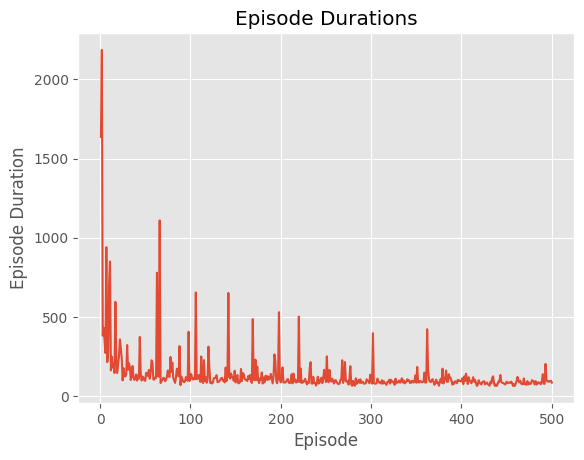

In [ ]:
episodes = range(1, num_episodes + 1)
plt.plot(episodes, episode_durations)
plt.xlabel('Episode')
plt.ylabel('Episode Duration')
plt.title('Episode Durations')
plt.show()

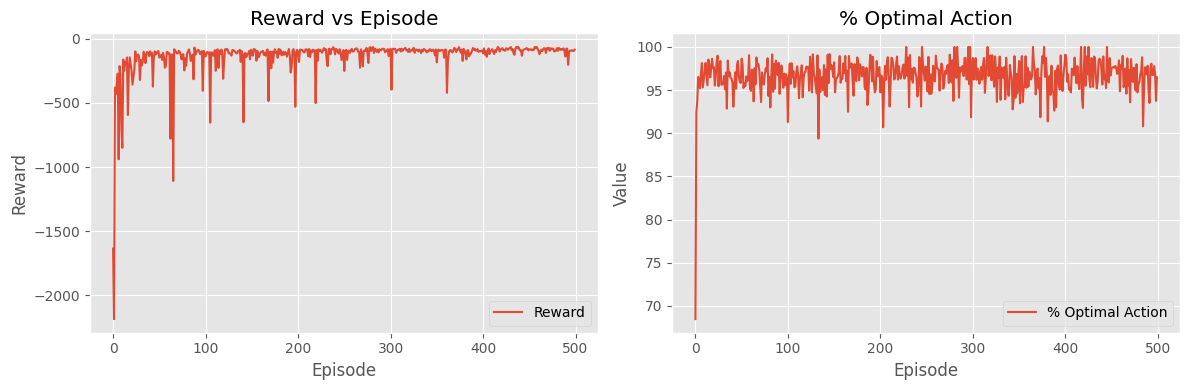

In [ ]:
# Function to plot average rewards and optimal action percentages in subplots
def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.set_title("Reward vs Episode")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.plot(total_rewards, label="Reward")
    ax1.legend(loc="lower right")

    ax2.set_title("% Optimal Action")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Value")
    ax2.plot(optimal_action_percentages, label="% Optimal Action")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics()

### Play a game with Trained model agent

In [ ]:
# Initialize the environment
env = gym.make("Acrobot-v1", render_mode = 'rgb_array')

# Test the trained agent and render the environment
state = env.reset(seed = 13)
state = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)
done = False
frames = []
env.reset()
total_reward = 0

# Main loop
while not done:
    # Select action based on trained policy_net
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)

    # Step the environment
    observation, reward, terminated, truncated, info = env.step(action.item())
    done = terminated or truncated
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward += reward

    # Render the environment
    frame = env.render()
    frames.append(frame)

# Close the environment
env.close()
print("Game terminated after", len(frames),  "steps with reward ", total_reward)
# save_frames_as_gif(frames, path='/content/', filename='trained_agent.gif')

Game terminated after 79 steps with reward  -78.0


Saving the game as a gif

In [ ]:
create_gif(frames, output_gif_path='/content/trained_agent.gif', duration=100)

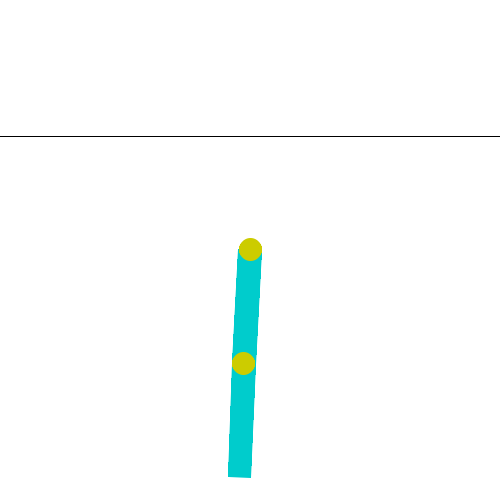

In [ ]:
display(Image(filename='/content/trained_agent.gif', width=400, height=300, embed=True))

# Average reward for trained agent on 100 games

Play 100 games with trained agent

In [ ]:
# play 100 games with the trained model
rewards = []
for i in range(100):
    state = env.reset()
    state = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    total_reward = 0
    steps = 0

    while not done:
      # Select action based on trained policy_net
      with torch.no_grad():
          action = policy_net(state).max(1)[1].view(1, 1)

      # Step the environment
      observation, reward, terminated, truncated, info = env.step(action.item())
      done = terminated or truncated
      state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
      total_reward += reward
      if reward != 0:
          steps += 1

    print("Game ", i+1, "terminated after", steps,  "steps with reward ", total_reward)
    rewards.append(total_reward)

trained_agent_mean = np.mean(rewards)
trained_agent_median = np.median(rewards)
trained_agent_std = np.std(rewards)
trained_agent_max = np.max(rewards)
trained_agent_min = np.min(rewards)

Game  1 terminated after 86 steps with reward  -86.0
Game  2 terminated after 77 steps with reward  -77.0
Game  3 terminated after 73 steps with reward  -73.0
Game  4 terminated after 76 steps with reward  -76.0
Game  5 terminated after 89 steps with reward  -89.0
Game  6 terminated after 82 steps with reward  -82.0
Game  7 terminated after 84 steps with reward  -84.0
Game  8 terminated after 69 steps with reward  -69.0
Game  9 terminated after 81 steps with reward  -81.0
Game  10 terminated after 70 steps with reward  -70.0
Game  11 terminated after 70 steps with reward  -70.0
Game  12 terminated after 79 steps with reward  -79.0
Game  13 terminated after 90 steps with reward  -90.0
Game  14 terminated after 70 steps with reward  -70.0
Game  15 terminated after 77 steps with reward  -77.0
Game  16 terminated after 79 steps with reward  -79.0
Game  17 terminated after 73 steps with reward  -73.0
Game  18 terminated after 78 steps with reward  -78.0
Game  19 terminated after 80 steps wi

Bar plot for the 100 games

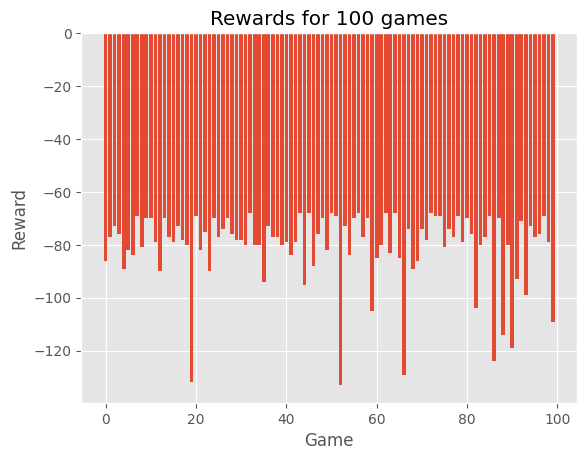

In [ ]:
# bar plot for rewards
plt.bar(range(len(rewards)), rewards)
plt.xlabel('Game')
plt.ylabel('Reward')
plt.title('Rewards for 100 games')
plt.show()

Performance of the trained agent

In [ ]:
print("Average reward: ", sum(rewards)/len(rewards))
print("Median reward: ", np.median(rewards))
print("Standard deviation: ", np.std(rewards))
print("Max reward: ", np.max(rewards))
print("Min reward: ", np.min(rewards))

Average reward:  -80.83
Median reward:  -77.0
Standard deviation:  14.095428336875756
Max reward:  -68.0
Min reward:  -133.0


# Comparing the performance

In [ ]:
performance_df = pd.DataFrame({
    'Agent': ['Trained Agent', 'Random Agent'],
    'Average Reward': [trained_agent_mean, random_agent_mean],
    'Median Reward': [trained_agent_median, random_agent_median],
    'Standard Deviation': [trained_agent_std, random_agent_std],
    'Max Reward': [trained_agent_max, random_agent_max],
    'Min Reward': [trained_agent_min, random_agent_min]
    })

In [ ]:
performance_df

,Agent,Average Reward,Median Reward,Standard Deviation,Max Reward,Min Reward
0,Trained Agent,-80.83,-77.0,14.095428,-68.0,-133.0
1,Random Agent,-499.00,-500.0,6.749815,-448.0,-500.0
